# Supervised Learning on Image Data

In the previous part of the course, you have learned about both supervised as unsupervised learning techniques. All of these techniques were applied to tabular datasets. In this part of the course, we will focus on supervised learning techniques applied to image data. Before the advance of deep learning, image data was often preprocessed and then fed into a traditional machine learning algorithm. This involved extracting characteristics or features from the image data and then using these features, in a tabular format, as input to the machine learning algorithm. To extract these features, domain knowledge was often required. The advantage of using handcrafted features is that they are interpretable. However, the disadvantage is that they are often not robust and generalizable. Especially for image data, handcrafted features often discard the local structure of the image data. In this notebook, we will show you how to use a selection of such handcrafted features to classify images. In the next notebook, we will show you how to use deep learning to classify images. You will see that deep learning is able to learn features from the image data itself, without the need for domain knowledge. This makes deep learning models more performant, robust, and generalizable.

In this notebook, we will use the Kaggle Cats and Dogs dataset. The aim is to classify images as either a cat or a dog. We will use a selection of handcrafted features to classify the images. There are two types of handcrafted features that you can use for images:
- **global features:** features that describe the image as a whole, such as the color histogram, mean color, standard deviation of color, fourier transform, PCA, etc.
- **local features:** features that describe the image at a local level, such as HOG(Histogram of Oriented Gradients), SIFT (Scale-Invariant Feature Transform), SURF (Speeded-Up Robust Features), and ORB (Oriented FAST and Rotated BRIEF).

As global features ignore all local information in the image, we will show you two local feature extractors here. First, we will show you how to use a HOG feature extractor. After that, we will show another local feature extractor, SIFT, to classify images. We will train a multi-layer perceptron for both feature extractors. The performance of these models will provide a baseline for the deep learning model that we will train in the next notebook. We will start by loading the data. To load the cats and dogs data, we will use the `load_dataset` function from the [HuggingFace](https://huggingface.co) library. [HuggingFace](https://huggingface.co) is a website that hosts a large number of datasets and trained models that you can use for machine learning. 

In [ ]:
!pip install datasets 

In [24]:
from datasets import load_dataset

dataset = load_dataset("cats_vs_dogs", split="train")

/Users/timdejong/.pyenv/versions/ai_course/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


## Create a sample of images

The cats and dogs dataset is quite large. If we would use the entire dataset, the processing time would be too long. Therefore, we will create a sample of the dataset. We will also use the images that have a width of at least 300 pixels. From this selection, we create a sample of 500 images.

In [ ]:
from itertools import islice
import numpy as np

def memory_efficient_sampler(dataset, sample_size, width_threshold=300, batch_size=100):
    """
    Yields indices of selected wide images in memory-efficient batches
    """
    selected = 0
    
    # Create shuffled indices
    all_indices = np.random.permutation(len(dataset))
    print("all indices", all_indices)
    
    # Process dataset in batches
    for i in range(0, len(all_indices), batch_size):
        batch_indices = all_indices[i:min(i + batch_size, len(all_indices))]
        batch = dataset.select(batch_indices)
        
        # Find wide images in current batch
        selected_batch_indices = [idx for idx, img in enumerate(batch['image']) 
                        if img.size[0] > width_threshold ]
        wide_indices = [batch_indices[idx] for idx in selected_batch_indices]

        # Randomly select from current batch
        batch_selection = np.random.choice(
            wide_indices, 
            size=min(len(wide_indices), sample_size - selected),
            replace=False
        ).tolist()
        
        # Update tracking
        selected += len(batch_selection)
        
        # Yield selected indices
        yield from batch_selection
        
        if selected >= sample_size:
            break

In [ ]:
selected_indices = list(memory_efficient_sampler(dataset, sample_size=500))
dataset = dataset.select(selected_indices)

X = dataset['image']
y_true = dataset['labels']

## Crop all images to have the same size

For the HOG feature extractor, it is important that all the images have the same width and height. The HOG feature extractor splits the cells of a certain size. If the images have different sizes, some images will have more cells than others. This will result in a different number of features for each image. Most machine learning algorithms cannot deal with feature vectorss of different lengths. Therefore, first we will look at the images sizes present in the dataset and then resize all images to the same size.  

In [26]:
import pandas as pd

image_sizes = [{"width": image.size[0], "height": image.size[1]} for image in X]
image_size_df = pd.DataFrame(image_sizes)
image_size_df.head()

width  height
0    500     375
1    420     500
2    500     346
3    500     332
4    500     375

And create a histogram of the width and height of the images.

array([[<Axes: title={'center': 'width'}>,
        <Axes: title={'center': 'height'}>]], dtype=object)

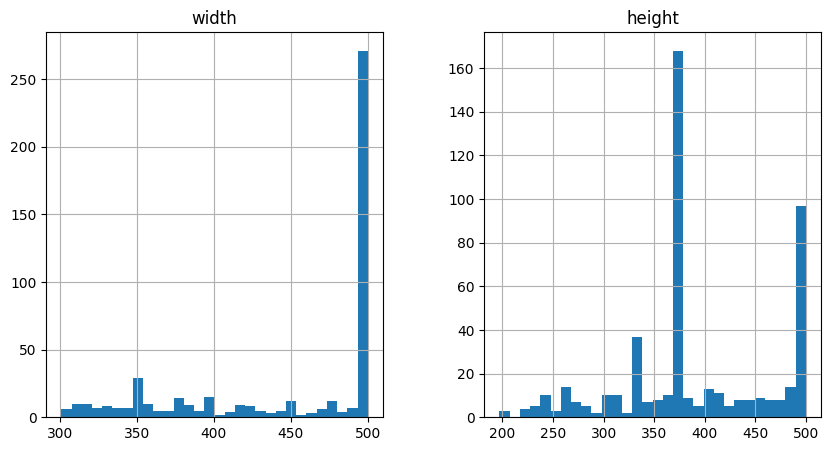

In [27]:
image_size_df.hist(bins=30, figsize=(10, 5))

Above we see that the images have different sizes. The images in our sample are between 300 and 500 pixels wide, and between 200 and 500 pixels high. We see that there is quite a large amount of images that are 500 pixels wide, and there are also a lot of images that are 375 pixels or 500 high. We will crop/resize all images to have the same size. We will crop the images to 300x300 pixels.

In [28]:
import tqdm

new_width = 300
new_height = 300

X_cropped = []
for image in tqdm.tqdm(X):
    width, height = image.size
    x_left = (width - new_width) // 2
    y_top = (height - new_height) // 2
    x_right = x_left + new_width
    y_bottom = y_top + new_height
    image = image.crop((x_left, y_top, x_right, y_bottom))
    X_cropped.append(image)


100%|██████████| 500/500 [00:00<00:00, 17904.02it/s]


## Split the data into a training and test set

Like was the case for the Titanic dataset, we should split the data into a training and test set. We will use the training set to train the model and the test set to evaluate the model. We will use 80% of the data for training and 20% of the data for testing. We will use the `train_test_split` function from the `sklearn` library to split the data.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cropped, y_true, test_size=0.2, random_state=42)

## Some image examples

Before we extract the features and train a machine learning algorithm, let's first take a look at some examples of the images in the dataset. Every time you run the cell below, a random image of our sample will be shown.

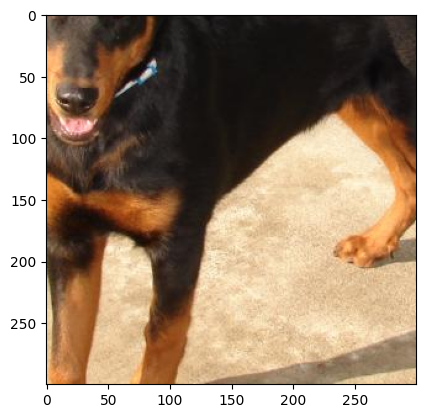

In [30]:
import matplotlib.pyplot as plt
import random

image = X_train[random.randint(0, len(X_train)-1)]
plt.imshow(image)

Let's check the size of the image as well. All images should be 300x300 pixels.

In [31]:
image.size

(300, 300)

## Feature extractor 1: Histogram Of Oriented Gradients (HOG)

First, we will use a Histogram of Oriented Gradients (HOG) feature extractor to extract features from the images. The HOG feature extractor counts the occurrences of gradient orientation in localized portions of an image, each orientation is weighted by the magnitude of the gradient. The image is split into cells for which the histograms are calculated. In the example below, it splits the image in cells of a certain size (8x8 pixels below) and looks at the gradient orientations in that part of the image. With an image size of 300x300 pixels, this results in 37x37 cells for the HOG. The histograms per cell are (optionally) normalized over greater blocks (`cells_per_block` below) to account for local variations in image intensity. The resulting histograms are then concatenated into a final feature vector per image.  We will use the `hog` function from the `skimage` library to extract the HOG features from the images.  Let's first look how the HOG features look like for a single image.

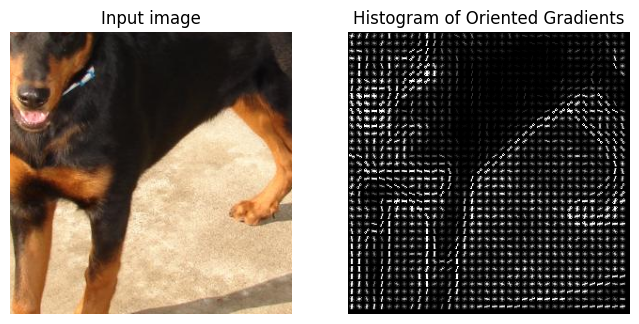

In [32]:
from skimage.feature import hog
from skimage import exposure


def hog_feature_vector(image):
    feature_vector, hog_image = hog(
        image,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(1, 1),
        visualize=True,
        feature_vector=True,
        channel_axis=-1,
        )
    return feature_vector, hog_image

feature_vector, hog_image = hog_feature_vector(image)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

We can clearly see the gradient orientations in the image. Next, let's extract the HOG features for the training set.

In [33]:
import tqdm

X_train_features = []

for image in tqdm.tqdm(X_train):
    X_train_features.append(hog_feature_vector(image)[0])

100%|██████████| 400/400 [00:26<00:00, 15.17it/s]


We see that each of the 400 images have a 10952 (37 blocks x 37 blocks x 8 orientations) dimensional HOG feature vector.

In [34]:
X_train_features = np.array(X_train_features)
X_train_features.shape

(400, 10952)

## Train a machine learning model

After extracting the features, we will train a machine learning model. We are using the `LinearSVC` from the `sklearn` library. This trains a Support Vector Machine Classifier (SVC) model. 

In [35]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=1)
clf.fit(X_train_features, np.array(y_train))

LinearSVC(random_state=1)

## Evaluate

After training the model, we will evaluate the model on the test set. We first need to extract the features for the test set images. 

In [36]:
X_test_features = []
for image in tqdm.tqdm(X_test):
    X_test_features.append(hog_feature_vector(image)[0])

100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


Like we did in the Titanic notebooks, we will use the `classification_report` function from the `sklearn` library to evaluate the model. This function returns the precision, recall, and F1-score of the model.

In [37]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test_features)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.43      0.47        42
           1       0.63      0.71      0.67        58

    accuracy                           0.59       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.58      0.59      0.58       100



We will also plot the confusion matrix to evaluate the model.

<Axes: >

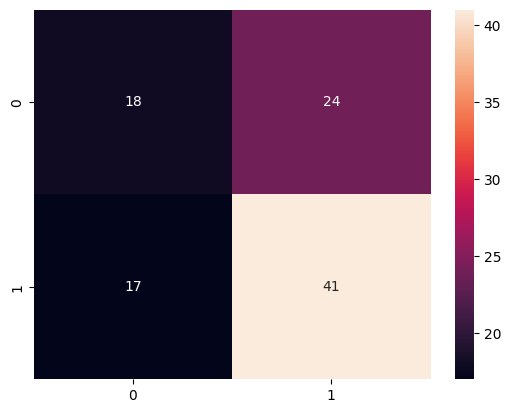

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

We see that, while we are able to classify some images correctly using the HOG features, there's room for improvement for all performance metrics.

## Using SIFT and Bag of Visual Words

Next, we will use the Scale-Invariant Feature Transform (SIFT) feature extractor to extract features from the images. SIFT is a local feature extractor that extracts keypoints and descriptors from the image. The keypoints are the points in the image that are distinctive and can be used to describe the image. The descriptors are the features that describe the keypoints. A SIFT descriptor is based on the histogram of oriented gradients. We will use the `SIFT` class from the `skimage.feature` library to extract the SIFT features from the images. 

Whereas HOG extracts one feature vector per image, SIFT extracts a feature per keypoint. In addition, the number of keypoints per image can vary. To use the SIFT features in a machine learning algorithm, we will need to process these separate features further. We will use the Bag of Visual Words technique to create a fixed-length feature vector per image. You can think of the Bag of Visual Words as a sort of dictionary; it contains a number of visual words. Visual words are the cluster-centers of the SIFT descriptors. These should be somewhat representative of the SIFT descriptors in the dataset. Each image is now described in terms of these visual words (cluster-centers) by creating a histogram, i.e. counting the occurences, of the visual words in the image. 

We create the Bag of Visual Words by clustering the SIFT descriptors into a number of clusters. To do this, we will use the `kmeans` function from the `sklearn` library. We cluster the SIFT descriptors in 100 clusters and use the cluster centers as visual words. We will use the `histogram` function from the `numpy` library to create a histogram of the clusters per image. The histogram will be the resulting feature vector for the image. The code below shows how to extract the SIFT features and create the Bag of Visual Words.  

In [39]:
from sklearn.cluster import KMeans
from skimage.feature import SIFT
from skimage.color import rgb2gray

class BagOfVisualWords:
    def __init__(self, n_clusters=100):
        self.kmeans = KMeans(n_clusters=n_clusters)
        self.sift = SIFT()
        self.__n_clusters = n_clusters

    @property
    def n_clusters(self):
        return self.__n_clusters

    def fit(self, X):
        descriptors = []
        for image in tqdm.tqdm(X):
            image = np.array(image)
            greyscale_image = rgb2gray(image)
            self.sift.detect_and_extract(greyscale_image)
            for i in range(self.sift.descriptors.shape[0]):
                descriptors.append(self.sift.descriptors[i, :])
        self.kmeans.fit(np.array(descriptors))
        return self

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def transform(self, X):
        bovw = np.zeros((len(X), self.n_clusters))

        for i, image in enumerate(tqdm.tqdm(X)):
            image = np.array(image)
            greyscale_image = rgb2gray(image)
            self.sift.detect_and_extract(greyscale_image)
            image_clusters = self.kmeans.predict(self.sift.descriptors)
            bovw[i] = np.bincount(image_clusters, minlength=self.n_clusters)
        return bovw

bag_of_visual_words = BagOfVisualWords(n_clusters=100)

Using the Bag Of Visual Words class, we will extract feature vectors for each image in the training set:

In [40]:
bovw_train = bag_of_visual_words.fit_transform(X_train)
bovw_train.shape


100%|██████████| 400/400 [01:03<00:00,  6.34it/s]


(400, 100)

And then train a classifier on the training set. We will use the `LinearSVC` from the `sklearn` library. This trains a Support Vector Machine Classifier (SVC) model.

In [41]:
clf = LinearSVC(random_state=1)
clf.fit(bovw_train, y_train)

LinearSVC(random_state=1)

## Evaluate

Again, we will evaluate the model on the test set. First, we will extract features for the test set images.

In [42]:
bovw_test = bag_of_visual_words.transform(X_test)
bovw_test.shape

100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


(100, 100)

Using the train classifiers we will predict the labels of the test set images and evaluate the model using the `classification_report` function from the `sklearn` library. This function returns the precision, recall, and F1-score of the model.

In [43]:
y_pred = clf.predict(bovw_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.71      0.65        42
           1       0.76      0.64      0.69        58

    accuracy                           0.67       100
   macro avg       0.67      0.68      0.67       100
weighted avg       0.69      0.67      0.67       100



We also will plot the confusion matrix for the model.

<Axes: >

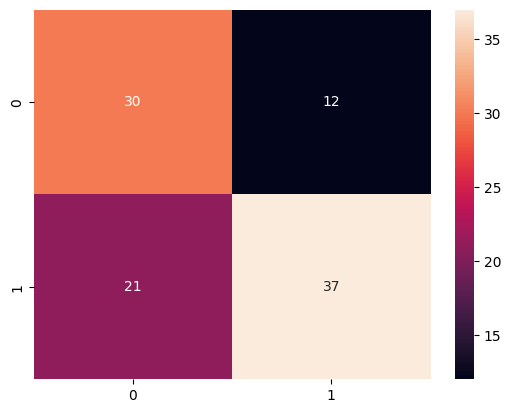

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

We see that the SIFT/Bag of Visual Words model performs similar than the HOG model. Depending on the dataset, sometimes the HOG and sometimes the SIFT feature extractor performs marginally better. In the next notebook, we will see that deep learning models easily outperform these models.

# Conclusion

In this notebook, we have shown you how to use handcrafted features to classify images. Handcrafted-features turn characteristics of an image into a tabular representation that can be used with the machine learning classifiers we have seen so far. Here, we have used the HOG and SIFT feature extractors to extract features from the images. HOG directly extracts features from the image data, while SIFT extracts keypoints and descriptors from the image data. For SIFT, we need further processing to create a fixed-length feature vector per image. For this, we used a Bag of Visual Words technique. We trained a `LinearSVC` model on both the HOG and SIFT features and evaluated each of these models. Model performance left room for improvement. In the next notebook, we will show you how to use deep learning to classify images. You will see that deep learning models are able to learn features from the image data itself, without the need for domain knowledge. This makes deep learning models more performant, robust, and generalizable.

For a comparison of HOG and SIFT see [here](https://medium.com/@danyang95luck/comparison-of-hog-histogram-of-oriented-gradients-and-sift-scale-invariant-feature-transform-e2b17f61c9a3)